# Load .mat file

From DeCourcy 2022 paper (to be published)

In [1]:
import sandbox as sb
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
import os

In [2]:
filePath = '/Users/ivanaescobar/work/regionalgcm/data/paper_decourcy_22/'
if (os.uname()[0] == 'Linux'):
    filePath = '/home/ivana/regionalgcm/data/paper_decourcy_22/'
fileName = 'SSP_only.mat'
file = filePath + fileName

In [3]:
mat = sb.loadMatFile(file)
keys_to_remove = ("__header__", "__version__", "__globals__")
for k in keys_to_remove:
    mat.pop(k, None)

In [4]:
print(type(mat))
print(mat.keys())

<class 'dict'>
dict_keys(['ssp'])


# Convert to xarray DataSet

modify dictionary to use **from_dict** xarray method

only saving:
- *ssp*: Dimension of dataSet
- *x*: Dimension of ranges
- *z*: Dimension of depths 

Other info: 
* Send source signature from TM4 experiment for time series modeling : \
TM4 source 4 second long chirp, bandwidth 775 Hz – 475 Hz.  Source depth:  81 m \
* Send lat, lon, depth coordinates of TM4 and AT: \
TM4:  39° 50.8542'N 70° 54.0876'W;  \
AT:  39° 57.150'N   70° 53.167'W

In [6]:
tm4 = [sb.degMinSec2decimal(39,50.8542), -sb.degMinSec2decimal(70,54.0876)]
at  = [sb.degMinSec2decimal(39,57.1500), -sb.degMinSec2decimal(70,53.1670)]

nesbaDist = sb.wgs84Distance(at[0],  at[1],
                 tm4[0], tm4[1]) / 1000.
print(nesbaDist)

11.722506037872984


In [7]:
import xarray as xr

In [8]:
def makeDataSet (matlabDictionary):
    # IN: MATLab mat file loaded,
    # OUT: ds DataSet
    
    x0 = -300; x1 = 12000; dx = 300 #[m]
    z0 = 0;    z1 = 4356;  dz = 2   #[m]

    ranges = np.linspace(x0,x1, num=int((x1-x0)/dx)+1)/1000.
    r = np.arange(0, len(ranges))
    zs = np.linspace(z0,z1, num=int((z1-z0)/dz)+1)
    z = np.arange(0, len(zs))
    
    # *eye_roll* manual depths
    depths = [872.306667 + (872-814)/1.02, 872.306667, 814.285143, 759.290286, 
              695.28219 , 648.044134, 603.89386 ,
       564.748982, 537.740158, 515.170275, 489.650608, 460.15    , 426.312952,
       398.631619, 374.715286, 347.545878, 323.726735, 299.907592, 278.019061,
       258.685633, 239.35975 , 222.623846, 207.366378, 191.446667, 179.840573,
       168.990479, 158.536616, 153.33193 , 147.815445, 143.699694, 142.094137,
       140.420645, 138.742602, 137.303484, 135.940938, 134.578693, 133.216449,
       131.779538, 130.084454, 128.484929, 127.089131, 125.693333]
    rdepth = [ -0.3, 0.      ,  1.028222,  2.056373,  3.084453,  4.112055,  5.13488 ,
        6.157705,  7.180532,  8.203324,  9.226077, 10.248831, 11.271927,
       12.301135, 13.33024 , 14.359243, 15.390253, 16.427994, 17.465476,
       18.5027  , 19.544329, 20.58843 , 21.632136, 22.664496, 23.694439,
       24.724242, 25.753907, 26.783432, 27.812819, 28.842068, 29.871179,
       30.909604, 31.971244, 33.032005, 34.086548, 35.132275, 36.177451,
       37.222079, 38.252856, 39.276854, 40.300824, 41.324765]
    rr = np.arange(0, len(rdepth))
    
    d = {
        "r":     {"dims": ("r"),     "data":list(r)},
        "z":     {"dims": ("z"),     "data":list(z)},
        "rr":    {"dims": ("rr"),    "data":list(rr)},
        "zs":    {"dims": ("z"),     "data":list(zs)},
        "range": {"dims": ("r"),     "data":list(ranges)},
        "depth": {"dims": ("rr"),    "data":depths},
        "rdepth":{"dims": ("rr"),    "data":rdepth},
        "ss":    {"dims": ("z","r"), "data":matlabDictionary["ssp"][:,0,:].T.tolist()}
    }
    ds = xr.Dataset.from_dict(d)
    ds = ds.sortby('r')
    
    # Assign attributes
    ds.range.attrs['long_name'] = 'range'
    ds.range.attrs['unit'] = 'km'
    ds.z.attrs['long_name'] = 'depth'
    ds.z.attrs['unit'] = 'm'
    ds.depth.attrs['long_name'] = 'maximum depth'
    ds.depth.attrs['unit'] = 'm'
    ds.ss.attrs['long_name'] = 'sound speed'
    ds.ss.attrs['unit'] = 'm/s'
    
    return ds

In [9]:
ds    = makeDataSet(mat)

In [10]:
ds = ds.sel(z=slice(0,1000))
ds.coords['r'] = ds.range
ds

<xarray.Dataset>
Dimensions:  (r: 42, z: 1001, rr: 42)
Coordinates:
  * r        (r) float64 -0.3 0.0 0.3 0.6 0.9 1.2 ... 10.8 11.1 11.4 11.7 12.0
  * z        (z) int64 0 1 2 3 4 5 6 7 8 ... 993 994 995 996 997 998 999 1000
  * rr       (rr) int64 0 1 2 3 4 5 6 7 8 9 10 ... 32 33 34 35 36 37 38 39 40 41
Data variables:
    zs       (z) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
    range    (r) float64 -0.3 0.0 0.3 0.6 0.9 1.2 ... 10.8 11.1 11.4 11.7 12.0
    depth    (rr) float64 929.2 872.3 814.3 759.3 ... 130.1 128.5 127.1 125.7
    rdepth   (rr) float64 -0.3 0.0 1.028 2.056 3.084 ... 38.25 39.28 40.3 41.32
    ss       (z, r) float64 1.496e+03 1.496e+03 1.496e+03 ... 1.47e+03 1.47e+03

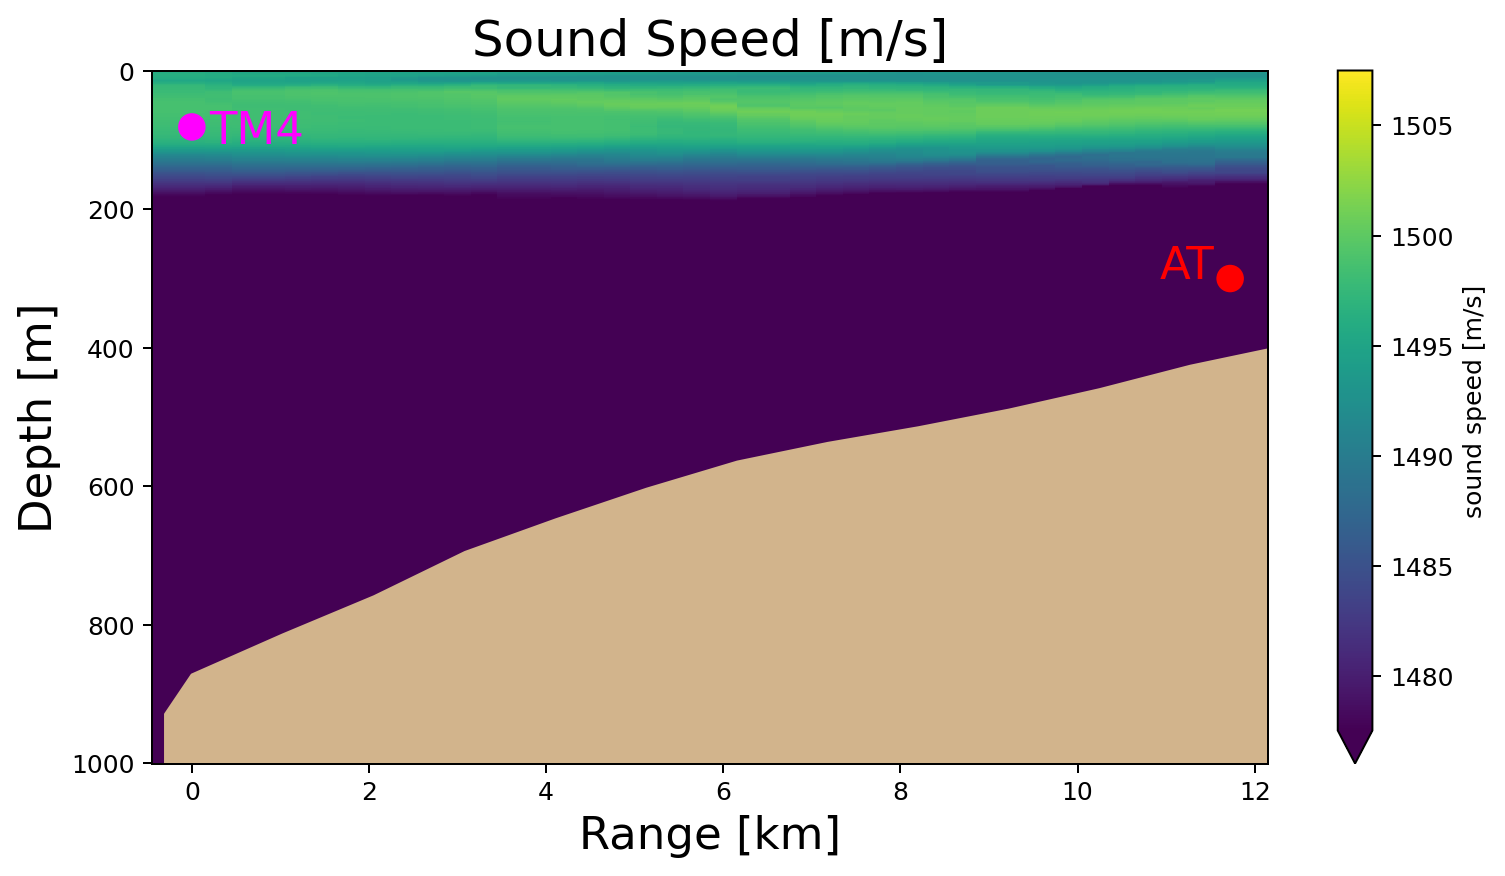

In [11]:
plt.figure(figsize=(10,5), dpi=180)
ds.ss.plot(yincrease=False, vmin=1477.53, vmax=1507.49)

# Add nesba experimental locations
plt.scatter([ds['r'].isel(r=1), nesbaDist], 
            [81., 300.] , 
            color=['magenta', 'red'],
            s=100)
plt.text( ds['r'].isel(r=1)+2e-1, 105., 'TM4', fontsize=18, color='magenta' )
plt.text( nesbaDist-.8, 300., 'AT', fontsize=18, color='red' )

# Add bathymetry
plt.fill_between(ds.rdepth, ds.depth, 1000, color='tan')

# labels
plt.xlabel('Range [km]', fontsize=18)
plt.ylabel('Depth [m]', fontsize=18)
plt.title('Sound Speed [m/s]', fontsize=20)


plt.savefig(filePath+'nesba-tm4_ssp-data_BD22.png')

# Save data set to netcdf

In [10]:
runName = 'nesba-tm4-BD22_ssp'
if (os.uname()[0] == 'Linux'):
    runName = 'nesba-tm4-BD22_ssp_sverdrup'
ds.to_netcdf(filePath+runName+'.nc')

# Write SSPFile

BELLHOP SSPFile is written as follows: 

`number of SSP Ranges, SSP%Nr`\
`ranges in km`\
`SSP for each range at z(1)`\
`...`\
`SSP for each range at z(1001)`

In [12]:
runName = 'nesba-tm4_BD22'
#ds = ds.sel(r=slice(0,11.4))

In [13]:
fileSSP = runName + '.ssp'

nPtsSSP = len(ds.r)

In [14]:
dataSSP = np.vstack([ds.r, ds.ss])

In [15]:
np.savetxt(filePath+fileSSP, 
           dataSSP, fmt='%0.6f', 
           header=str(nPtsSSP), comments='',
           delimiter='\t')

# Write first column of SSP in ENVFile

BELLHOP ENVFile requires there be # of depths amount of rows with dummy SSP values to read in. It uses this to dtermine how big the SSPFile will be and will allocate memory for the SSP matrices with this.

In [16]:
dataENV = np.column_stack([ds.z, ds.ss.isel(r=0)])

In [17]:
np.savetxt(filePath+runName+'-extension.env', 
           dataENV, fmt=['%0.1f', '%0.6f'], 
           delimiter='\t',
           newline='\t/\n')

<sub> Written by Ivana Escobar on Sept 2022